In [1]:
import pandas as pd
import numpy as np
from dataretrieval import nwis
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import folium
from folium.plugins import HeatMap
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
sites_df, sites_md = nwis.get_info(stateCd='CA', siteStatus='active')
site_list = sites_df['site_no'].tolist()

Using the nwis dataretrieval tool to plug in to the USGS well data and look for the information about all active reporting stations that are located in CA. This information includes their station type (eg. Stream, Lake, Groundwater, ...), their coordinates, their hole depth, etc. depending on the station type.

In [3]:
sites_df.head()

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
0,USGS,09423350,CARUTHERS C NR IVANPAH CA,ST,351442.02,1151756.36,35.245006,-115.298989,M,5,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USGS,09423500,"COLORADO RIVER AT NEEDLES, CA",ST,345106.02,1143636.61,34.851672,-114.610169,X,H,...,N,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,CHI
2,USGS,09427500,"LAKE HAVASU NEAR PARKER DAM, AZ-CA",LK,341858.00,1140923.00,34.316126,-114.157170,M,T,...,N,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,CHI
3,USGS,09429000,"PALO VERDE CANAL NEAR BLYTHE, CA",ST-CA,334353.77,1143043.01,33.731603,-114.511947,X,H,...,N,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,CHI
4,USGS,09429100,"COLORADO RIVER BELOW PALO VERDE DAM, AZ-CA",ST,334308.89,1142951.14,33.719136,-114.497539,X,H,...,N,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
gw = sites_df[sites_df.site_tp_cd == "GW"].copy()

Isolating stations that are deignated GW for a groundwater measurement station.

In [5]:
gw.head()

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
833,USGS,323313117033901,019S002W02C007S,GW,323313.12,1170341.77,32.553644,-117.061603,D,H,...,Y,C,YYNNNYYN,N100CACSTL,NaN,C,1360.0,1430.0,S,470600319
834,USGS,323313117033902,019S002W02C008S,GW,323313.12,1170341.77,32.553644,-117.061603,D,H,...,Y,C,YYNNNYYN,N100CACSTL,NaN,C,1190.0,1430.0,S,470600319
835,USGS,323313117033903,019S002W02C009S,GW,323313.12,1170341.77,32.553644,-117.061603,D,H,...,Y,C,YYNNNYYN,N100CACSTL,NaN,C,965.0,1430.0,S,970600319
836,USGS,323313117033904,019S002W02C010S,GW,323313.12,1170341.77,32.553644,-117.061603,D,H,...,Y,C,YYNNNYYN,N100CACSTL,NaN,U,600.0,1430.0,S,470600319
837,USGS,323313117033905,019S002W02C011S,GW,323313.12,1170341.77,32.553644,-117.061603,D,H,...,Y,C,YYNNNYYN,N100CACSTL,NaN,U,280.0,1430.0,S,470600319


In [6]:
data, meta = nwis.get_gwlevels(sites="323313117033901", datetime_index=False)

Looking at the structure of the data for a given GW site to make sure my later transformations will work for stations.

In [7]:
data.head()

,agency_cd,site_no,site_tp_cd,lev_dt,lev_tm,lev_tz_cd,lev_va,sl_lev_va,sl_datum_cd,lev_status_cd,lev_agency_cd,lev_dt_acy_cd,lev_acy_cd,lev_src_cd,lev_meth_cd,lev_age_cd,parameter_cd
0,USGS,323313117033901,GW,1995-07-17,NaN,NaN,NaN,-7.40,NGVD29,1.0,NaN,D,2,NaN,V,A,62610
1,USGS,323313117033901,GW,1995-07-17,NaN,NaN,NaN,-5.23,NAVD88,1.0,NaN,D,2,NaN,V,A,62611
2,USGS,323313117033901,GW,1995-07-17,NaN,NaN,50.49,NaN,NaN,1.0,NaN,D,2,NaN,V,A,72019
3,USGS,323313117033901,GW,1995-07-25,NaN,NaN,NaN,-7.47,NGVD29,1.0,NaN,D,2,NaN,V,A,62610
4,USGS,323313117033901,GW,1995-07-25,NaN,NaN,NaN,-5.30,NAVD88,1.0,NaN,D,2,NaN,V,A,62611


In [8]:
# data['lev_dt'] = pd.to_datetime(data['lev_dt'])

# # Convert lev_tm to string, slice to keep only hours and minutes, then parse as time
# data['lev_tm'] = pd.to_datetime(data['lev_tm'].astype(str).str[:5], format='%H:%M').dt.time

# # Sort by lev_dt and lev_tm
# data = data.sort_values(by=['lev_dt', 'lev_tm']).reset_index(drop=True)

# data['datetime'] = pd.to_datetime(data['lev_dt'].astype(str) + ' ' + data['lev_tm'].astype(str))

In [9]:
data.head()

,agency_cd,site_no,site_tp_cd,lev_dt,lev_tm,lev_tz_cd,lev_va,sl_lev_va,sl_datum_cd,lev_status_cd,lev_agency_cd,lev_dt_acy_cd,lev_acy_cd,lev_src_cd,lev_meth_cd,lev_age_cd,parameter_cd
0,USGS,323313117033901,GW,1995-07-17,NaN,NaN,NaN,-7.40,NGVD29,1.0,NaN,D,2,NaN,V,A,62610
1,USGS,323313117033901,GW,1995-07-17,NaN,NaN,NaN,-5.23,NAVD88,1.0,NaN,D,2,NaN,V,A,62611
2,USGS,323313117033901,GW,1995-07-17,NaN,NaN,50.49,NaN,NaN,1.0,NaN,D,2,NaN,V,A,72019
3,USGS,323313117033901,GW,1995-07-25,NaN,NaN,NaN,-7.47,NGVD29,1.0,NaN,D,2,NaN,V,A,62610
4,USGS,323313117033901,GW,1995-07-25,NaN,NaN,NaN,-5.30,NAVD88,1.0,NaN,D,2,NaN,V,A,62611


This is a DataFrame of all GW designated stations in CA that are active. The next process is to access the data for each of these stations and calculate some summary statistics for them:
- Latest date and time of report
- Earliest reported date
- Number of observations
- Average gap between observations
- Number of observations in the last 5 years

In [10]:
data_list = []

def add_row(data_list, site_id, lev_dt, lev_tm, earliest_dt, obs, gap, obs_last_5_years):
    data_list.append({
        'site_id': site_id,
        'latest_dt': lev_dt,
        'latest_tm': lev_tm,
        'earliest_dt': earliest_dt,
        'observations': obs,
        'obs_gap': gap,
        'obs_last_5_years': obs_last_5_years
    })

for point in tqdm(gw.site_no):
    try:
        data, meta = nwis.get_gwlevels(sites=point, datetime_index=False)
        data['lev_dt'] = pd.to_datetime(data['lev_dt'], errors='coerce')
        data['lev_tm'] = pd.to_datetime(data['lev_tm'].astype(str).str[:5], format='%H:%M', errors='coerce').dt.time
        data = data.dropna(subset=['lev_dt', 'lev_tm']).sort_values(by=['lev_dt', 'lev_tm']).reset_index(drop=True)
        
        # Get the latest and earliest observation dates
        latest = data.tail(1)[["lev_dt", "lev_tm"]].iloc[0].values
        earliest = data.head(1)[["lev_dt", "lev_tm"]].iloc[0].values
        
        # Count total observations
        observations = data[["lev_dt", "lev_tm"]].drop_duplicates().copy()
        observations["datetime"] = pd.to_datetime(observations['lev_dt'].astype(str) + ' ' + observations['lev_tm'].astype(str))
        total_observations = observations.shape[0]
        
        # Calculate average observation gap
        observations["timediff"] = observations["datetime"].diff()
        avg_gap = observations.timediff.dropna().mean()
        
        # Filter for observations in the last 5 years
        five_years_ago = datetime.now() - timedelta(days=5*365)
        obs_last_5_years = observations[observations['datetime'] >= five_years_ago].shape[0]
        
        # Add row to data_list using the add_row function
        add_row(data_list, point, latest[0], latest[1], earliest[0], total_observations, avg_gap, obs_last_5_years)
        
    except Exception as e:
        continue

# Convert list of dictionaries to DataFrame at the end
recent = pd.DataFrame(data_list)

 15%|█▌        | 226/1489 [03:43<21:36,  1.03s/it]<ipython-input-10-767784336ac8>:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  observations["datetime"] = pd.to_datetime(observations['lev_dt'].astype(str) + ' ' + observations['lev_tm'].astype(str))
 19%|█▉        | 287/1489 [05:01<20:03,  1.00s/it]  <ipython-input-10-767784336ac8>:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  observations["datetime"] = pd.to_datetime(observations['lev_dt'].astype(str) + ' ' + observations['lev_tm'].astype(str))
 21%|██        | 316/1489 [05:30<21:03,  1.08s/it]<ipython-input-10-767784336ac8>:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsin

Observations are grouped by unique date and time combination as output produces a row for each parameter_cd available with every time stamp that comes out.

In [11]:
recent.head()

,site_id,latest_dt,latest_tm,earliest_dt,observations,obs_gap,obs_last_5_years
0,323313117033901,2024-10-29,19:10:00,2005-08-29,190,37 days 01:01:09.841269841,45
1,323313117033902,2024-10-29,19:12:00,2005-08-29,192,36 days 15:42:36.125654450,44
2,323313117033903,2024-10-29,19:14:00,2005-08-29,188,37 days 10:31:37.540106952,44
3,323313117033904,2024-10-29,19:16:00,2005-08-29,182,38 days 16:18:44.088397790,43
4,323313117033905,2024-10-29,19:18:00,2005-08-29,187,37 days 15:21:26.451612903,43


In [12]:
recent = recent[pd.notnull(recent['obs_gap'])].copy()

# Ensure the obs_gap column is in timedelta format, if not already
recent['obs_gap'] = pd.to_timedelta(recent['obs_gap'])

# Calculate the average timedelta
average_obs_gap = recent['obs_gap'].mean()

In [13]:
average_obs_gap

Timedelta('313 days 08:10:06.977546468')

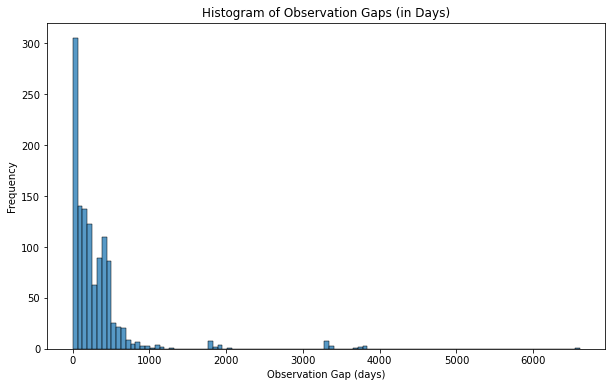

In [14]:
recent['obs_gap_days'] = recent['obs_gap'].dt.total_seconds() / (24 * 3600)  # Convert seconds to days

# Plot the histogram with Seaborn and automatic bin sizing for days
plt.figure(figsize=(10, 6))
sns.histplot(recent['obs_gap_days'], kde=False)  # kde=False for basic histogram
plt.xlabel('Observation Gap (days)')
plt.ylabel('Frequency')
plt.title('Histogram of Observation Gaps (in Days)')
plt.show()

Looking at the frequency of gaps between observations in days. We see from above that the expected gao between observations is approximately 312 days. Could this be due to very old sparse historic data? Added a count of observations for the last 5 years to look at whether this trend continues.

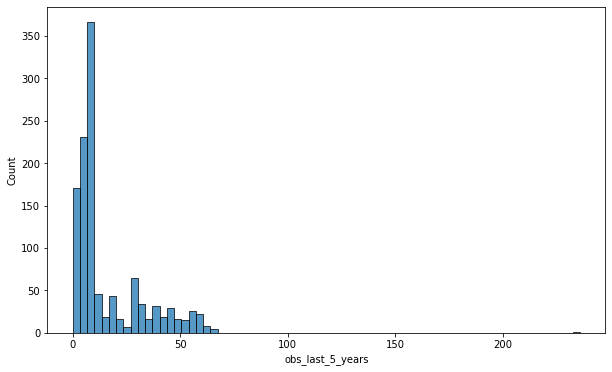

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(recent['obs_last_5_years'], kde=False)
plt.show()

Plot shows the number of published observations over the last 5 years, below summary statistics show the expected number of observations is around 16, or equivalently 3 per year.

In [16]:
recent.obs_last_5_years.describe()

count    1187.000000
mean       15.963774
std        17.516012
min         0.000000
25%         5.000000
50%         9.000000
75%        23.000000
max       236.000000
Name: obs_last_5_years, dtype: float64

Now left inner merging the GW stations we have built into the _recent_ df to look at their properties.

In [17]:
sites_df[sites_df.site_no.isin(recent.site_id)].head()

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
833,USGS,323313117033901,019S002W02C007S,GW,323313.12,1170341.77,32.553644,-117.061603,D,H,...,Y,C,YYNNNYYN,N100CACSTL,NaN,C,1360.0,1430.0,S,470600319
834,USGS,323313117033902,019S002W02C008S,GW,323313.12,1170341.77,32.553644,-117.061603,D,H,...,Y,C,YYNNNYYN,N100CACSTL,NaN,C,1190.0,1430.0,S,470600319
835,USGS,323313117033903,019S002W02C009S,GW,323313.12,1170341.77,32.553644,-117.061603,D,H,...,Y,C,YYNNNYYN,N100CACSTL,NaN,C,965.0,1430.0,S,970600319
836,USGS,323313117033904,019S002W02C010S,GW,323313.12,1170341.77,32.553644,-117.061603,D,H,...,Y,C,YYNNNYYN,N100CACSTL,NaN,U,600.0,1430.0,S,470600319
837,USGS,323313117033905,019S002W02C011S,GW,323313.12,1170341.77,32.553644,-117.061603,D,H,...,Y,C,YYNNNYYN,N100CACSTL,NaN,U,280.0,1430.0,S,470600319


This shows the station table filtered for our matching GW stations in _recent_. Now merging and plotting.

In [18]:
recent_sites = recent.merge(sites_df, left_on='site_id', right_on='site_no', how='inner')

New table contains our measured properties about each station alongside generic properties of the station.

In [19]:
center_lat = recent_sites['dec_lat_va'].mean()
center_lon = recent_sites['dec_long_va'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Add markers for each latitude and longitude in recent_sites
for _, row in recent_sites.iterrows():
    folium.Marker(
        location=[row['dec_lat_va'], row['dec_long_va']],
        popup=f"Site ID: {row['site_id']}"
    ).add_to(m)

# Display the map
m

Map for all stations in our set, now to look at a heat map to see if there's regions where we see more observations for the last 5 years.

In [20]:
center_lat = recent_sites['dec_lat_va'].mean()
center_lon = recent_sites['dec_long_va'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Prepare data for the heatmap: each entry is [latitude, longitude, intensity]
heat_data = [
    [row['dec_lat_va'], row['dec_long_va'], row['obs_last_5_years']]
    for _, row in recent_sites.iterrows()
    if not pd.isnull(row['dec_lat_va']) and not pd.isnull(row['dec_long_va'])
]

# Add the heatmap layer to the map
HeatMap(heat_data, radius=10, max_zoom=13).add_to(m)

# Display the map
m

Heat map attempts to show the number of observations per station for the last 5 years, doesn't show much as they interfere with each other and outlier at 236 skews the colour gradient. Let's now look at stations with at least 50 observations for the last 5 years.

In [21]:
center_lat = recent_sites['dec_lat_va'].mean()
center_lon = recent_sites['dec_long_va'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Prepare data for the heatmap: each entry is [latitude, longitude, intensity]
heat_data = [
    [row['dec_lat_va'], row['dec_long_va'], row['obs_last_5_years']]
    for _, row in recent_sites[recent_sites.obs_last_5_years >= 50].iterrows()
    if not pd.isnull(row['dec_lat_va']) and not pd.isnull(row['dec_long_va'])
]

# Add the heatmap layer to the map
HeatMap(heat_data, radius=10, max_zoom=13).add_to(m)

# Display the map
m

New sliding version to quickly adjust filtering parameters and look at where data is most prevalent.

In [22]:
center_lat = recent_sites['dec_lat_va'].mean()
center_lon = recent_sites['dec_long_va'].mean()

# Create two sliders for selecting the bounds for `obs_last_5_years`
min_obs = recent_sites['obs_last_5_years'].min()
max_obs = recent_sites['obs_last_5_years'].max()
lower_bound_slider = widgets.IntSlider(value=min_obs, min=min_obs, max=max_obs, step=1, description='Lower Bound')
upper_bound_slider = widgets.IntSlider(value=max_obs, min=min_obs, max=max_obs, step=1, description='Upper Bound')

# Display the sliders
display(lower_bound_slider, upper_bound_slider)

# Create an output widget to display the map
map_output = widgets.Output()
display(map_output)

# Function to update the heatmap based on slider values
def update_heatmap(change=None):
    # Clear the output widget
    with map_output:
        clear_output(wait=True)
        # Filter the DataFrame based on slider values
        filtered_data = recent_sites[
            (recent_sites['obs_last_5_years'] >= lower_bound_slider.value) &
            (recent_sites['obs_last_5_years'] <= upper_bound_slider.value)
        ]

        # Prepare the heatmap data
        heat_data = [
            [row['dec_lat_va'], row['dec_long_va'], row['obs_last_5_years']]
            for _, row in filtered_data.iterrows()
            if not pd.isnull(row['dec_lat_va']) and not pd.isnull(row['dec_long_va'])
        ]

        # Create a new map
        m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
        HeatMap(heat_data, radius=10, max_zoom=13).add_to(m)

        # Display the map
        display(m)

# Attach the update function to slider changes
lower_bound_slider.observe(update_heatmap, names='value')
upper_bound_slider.observe(update_heatmap, names='value')

# Initialize the map display
update_heatmap()

IntSlider(value=0, description='Lower Bound', max=236)

IntSlider(value=236, description='Upper Bound', max=236)

Output()

From adjusting slider, it looks like there are 3 or 4 regions that have stations with relatively frequent station reporting.

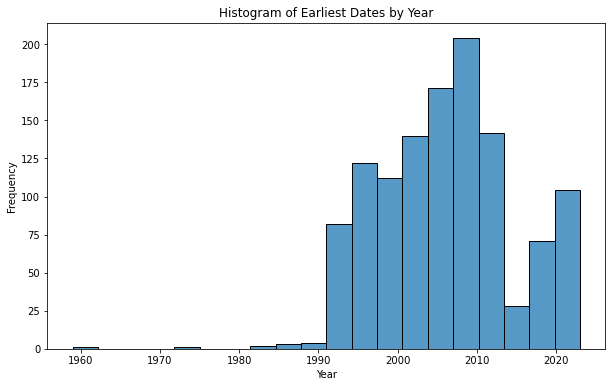

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(pd.to_datetime(recent['earliest_dt']).dt.year, bins=20)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of Earliest Dates by Year')
plt.show()

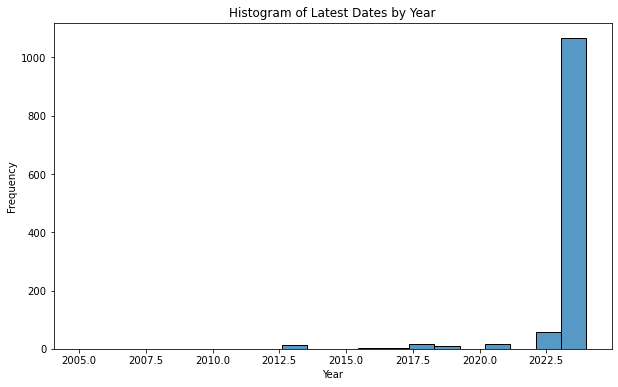

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(pd.to_datetime(recent['latest_dt']).dt.year, bins=20)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of Latest Dates by Year')
plt.show()

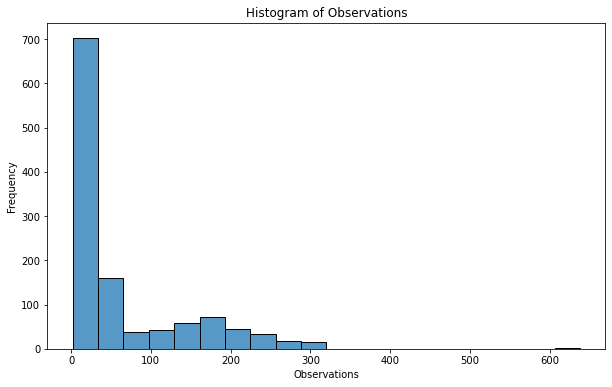

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(recent['observations'], bins=20)
plt.xlabel('Observations')
plt.ylabel('Frequency')
plt.title('Histogram of Observations')
plt.show()

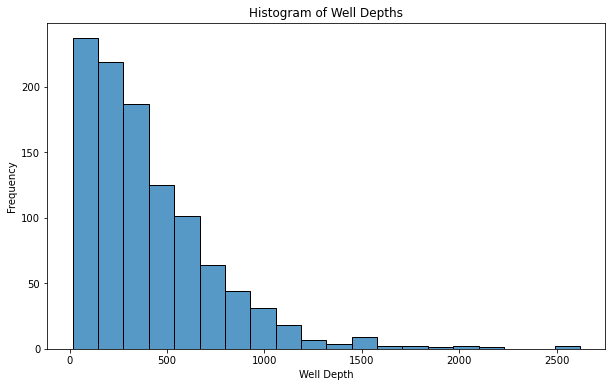

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(recent_sites['well_depth_va'], bins=20)
plt.xlabel('Well Depth')
plt.ylabel('Frequency')
plt.title('Histogram of Well Depths')
plt.show()

In [34]:
recent_sites.columns

Index(['site_id', 'latest_dt', 'latest_tm', 'earliest_dt', 'observations',
       'obs_gap', 'obs_last_5_years', 'obs_gap_days', 'agency_cd', 'site_no',
       'station_nm', 'site_tp_cd', 'lat_va', 'long_va', 'dec_lat_va',
       'dec_long_va', 'coord_meth_cd', 'coord_acy_cd', 'coord_datum_cd',
       'dec_coord_datum_cd', 'district_cd', 'state_cd', 'county_cd',
       'country_cd', 'land_net_ds', 'map_nm', 'map_scale_fc', 'alt_va',
       'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd', 'huc_cd', 'basin_cd',
       'topo_cd', 'instruments_cd', 'construction_dt', 'inventory_dt',
       'drain_area_va', 'contrib_drain_area_va', 'tz_cd', 'local_time_fg',
       'reliability_cd', 'gw_file_cd', 'nat_aqfr_cd', 'aqfr_cd',
       'aqfr_type_cd', 'well_depth_va', 'hole_depth_va', 'depth_src_cd',
       'project_no'],
      dtype='object')